# Cluster Stitching

In [2]:
import numpy as np
import flow
import os
import matplotlib.pyplot as plt
from munkres import Munkres
from scipy.cluster import hierarchy
import seaborn as sns
import random
import pandas as pd
from copy import deepcopy
from cascade import tca
from cascade import paths

In [3]:
mouse='OA27'
rank_num=10
match_by='simple_sim'
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
word='convinced'

In [4]:
# pars for loading tca data
pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}

# create datesorter
days = flow.DateSorter.frommeta(mice=[mouse], tags=None)

conds_by_day = []
oris_by_day = []
trialerr_by_day = []
neuron_ids_by_day = []
neuron_clusters_by_day = []
factors_by_day = []
day_list = []
df_list_tempo = []
df_list_tuning = []
df_list_index = []
# loop through days in FORWARD order
for day1 in days:

    # load dir
    load_dir = paths.tca_path(mouse, 'single',
                              pars=pars, word=word)
    tensor_path = os.path.join(load_dir, str(day1.mouse)
                               + '_' + str(day1.date)
                               + '_single_decomp_'
                               + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(load_dir, str(day1.mouse)
                                     + '_' + str(day1.date)
                                     + '_single_tensor_'
                                     + str(trace_type) + '.npy')
    input_ids_path = os.path.join(load_dir, str(day1.mouse)
                                  + '_' + str(day1.date)
                                  + '_single_ids_'
                                  + str(trace_type) + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse)
                             + '_' + str(day1.date)
                             + '_df_single_meta.pkl')

    # load your metadata, skip post reversal days
    meta = pd.read_pickle(meta_path)
    condition = meta['condition']
    orientation = meta['orientation']
    trialerror = meta['trialerror']
    if 'reversal1' in meta['learning_state'].unique() \
    or 'reversal2' in meta['learning_state'].unique():
        continue

    # skip days that do not have minus, AND neutral
    if 'minus' not in meta['condition'].unique() \
    or 'neutral' not in meta['condition'].unique() \
    or 'plus' not in meta['condition'].unique():
        continue
    
    # keep dates for user
    day_list.append(day1.date)
    
    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    ids = np.load(input_ids_path)

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

    cell_ids = {}  # keys are rank
    cell_clusters = {}
    itr_num = 0  # use only best iteration of TCA, index 0
    for k in sort_ensemble.results.keys():
        # factors are already sorted, so these will define
        # clusters, no need to sort again
        factors = sort_ensemble.results[k][itr_num].factors[0]
        max_fac = np.argmax(factors, axis=1)
        cell_clusters[k] = max_fac
        cell_ids[k] = ids[my_sorts[k-1]]
        
    # ------------- GET TUNING
    
    trial_weights = sort_ensemble.results[rank_num][0].factors[2][:, :]
    tuning_weights = np.zeros((3, rank_num))
    oris_to_check = [0, 135, 270]
    for c, ori in enumerate(oris_to_check):
        tuning_weights[c, :] = np.nanmean(trial_weights[orientation == ori, :], axis=0)
    # normalize using summed mean response to all three
    tuning_total = np.nansum(tuning_weights, axis=0)
    for c in range(len(oris_to_check)):
        tuning_weights[c, :] = np.divide(tuning_weights[c, :], tuning_total)
        
    # ------------ CREATE PANDAS DF 
    
    index = pd.MultiIndex.from_arrays([
        [day1.mouse] * rank_num,
        [day1.date] * rank_num,
        range(1, rank_num+1)
        ],
        names=['mouse', 'date', 'component'])
    tempo_df = pd.DataFrame(sort_ensemble.results[rank_num][0].factors[1][:, :].T, index=index)
    zero = tuning_weights[0,:].flatten()
    onethirtyfive = tuning_weights[1,:].flatten()
    twoseventy = tuning_weights[2,:].flatten()
    tuning_data = {'t0': zero, 't135': onethirtyfive, 't270': twoseventy}
    tuning_df = pd.DataFrame(tuning_data, index=index)
    df_list_tempo.append(tempo_df)
    df_list_tuning.append(tuning_df)
    df_list_index.append(pd.DataFrame(index=index))
    
    factors_by_day.append(sort_ensemble.results[rank_num][0])
    conds_by_day.append(condition)
    oris_by_day.append(orientation)

# concatenate all runs together in final dataframe
all_tempo_df = pd.concat(df_list_tempo, axis=0)
all_tuning_df = pd.concat(df_list_tuning, axis=0)
all_index_df = pd.concat(df_list_index, axis=0)

#     neuron_ids_by_day.append(cell_ids[rank_num])
#     neuron_clusters_by_day.append(cell_clusters[rank_num])
#     trialerr_by_day.append(trialerror)

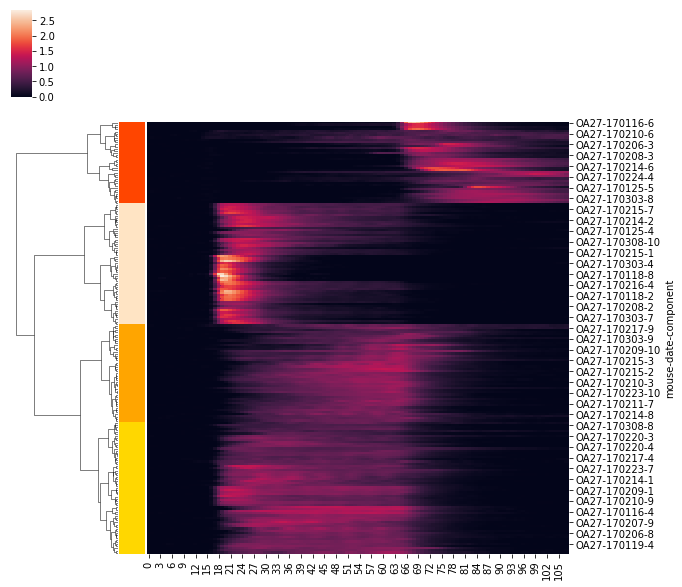

In [7]:
g = sns.clustermap(all_tempo_df, col_cluster=False, method='ward', row_colors=colors_shape)

In [6]:
row_sorter = g.dendrogram_row.reordered_ind
hierarchy.fcluster(g.dendrogram_row.linkage, 3, criterion='maxclust')[row_sorter]
hierarchy.fcluster(g.dendrogram_row.linkage, 8, depth=10)[row_sorter] #using inconcsitency
shape_cluster = hierarchy.fcluster(g.dendrogram_row.linkage, 4, criterion='maxclust')
color_options_shape = ['orangered', 'bisque', 'orange', 'gold']
colors_shape = [color_options_shape[i-1] for i in shape_cluster]
print(shape_cluster)

[2 4 3 4 1 1 4 2 3 1 3 2 2 4 1 4 4 2 1 1 1 1 4 4 3 4 4 4 2 2 2 3 3 2 1 3 3
 4 3 2 4 4 4 2 2 2 1 2 1 3 4 3 1 1 2 4 4 4 4 4 3 3 4 2 1 2 4 3 4 3 2 2 1 3
 4 4 4 1 3 2 4 2 1 1 3 3 4 2 4 3 3 4 3 2 3 1 1 4 4 2 1 2 4 4 4 4 3 2 3 2 4
 2 4 3 3 1 4 3 2 3 2 3 3 2 1 3 2 2 4 4 2 4 4 2 2 3 1 1 3 4 3 2 2 4 4 3 2 1
 3 4 2 1 4 4 4 2 3 1 1 3 2 2 4 3 1 1 4 2 2 3 3 4 1 1 4 2 2 2 2 4 1 2 2 2 4
 4 2 1 3 3 4 2 3 4 1 1 2 4 1 2]


In [ ]:
# sns.lineplot(all_tempo_df)
test = all_tempo_df.iloc[np.where(shape_cluster == 1)[0],:].as_matrix()
plt.plot(test.T)

(63, 108)

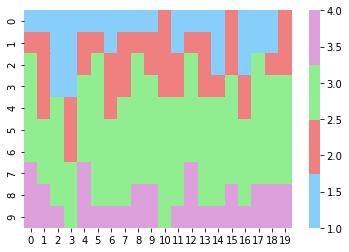

In [14]:
tuning_cluster_by_day = tuning_cluster.reshape((rank_num, -1))
tuning_pal = sns.color_palette(color_options_tuning)
sns.heatmap(np.sort(tuning_cluster_by_day, axis=0), cmap=tuning_pal)

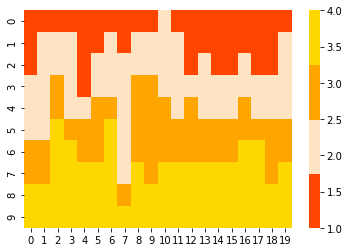

In [15]:
shape_cluster_by_day = shape_cluster.reshape((rank_num, -1))
shape_pal = sns.color_palette(color_options_shape)
sns.heatmap(np.sort(shape_cluster_by_day, axis=0), cmap=shape_pal)

[12 13 14 21 22 23 24 31 32 33 34 41 42 43 44]
10=neut, 20=minus, 30=plus, 40=broad, 1=off, 2=on, 3=sustained


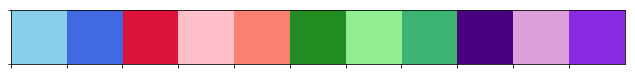

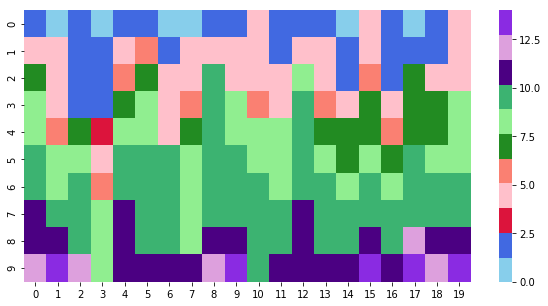

In [16]:
combo_cluster = shape_cluster_by_day+tuning_cluster_by_day*10
uni = np.unique(combo_cluster)
new_cluster = combo_cluster
print(uni)
print('10=neut, 20=minus, 30=plus, 40=broad, 1=off, 2=on, 3=sustained')
for c, i in enumerate(uni):
    new_cluster[new_cluster == i] = c
new_colors = ['skyblue', 'royalblue',
             'crimson', 'pink', 'salmon',
             'forestgreen', 'lightgreen', 'mediumseagreen',
             'indigo', 'plum', 'blueviolet']
new_pal = sns.color_palette(new_colors)
sns.palplot(new_pal)
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(np.sort(new_cluster, axis=0), cmap=new_pal, ax=ax)

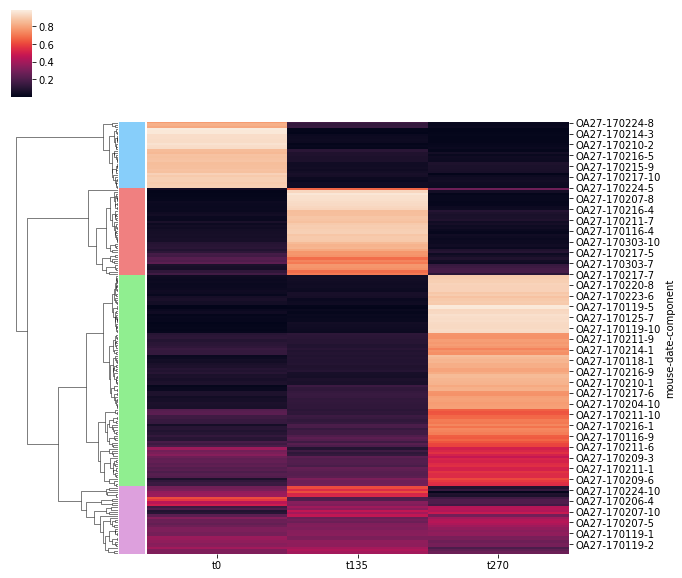

In [17]:
b = sns.clustermap(all_tuning_df, col_cluster=False, row_colors=colors_tuning)

In [12]:
row_sorter_tune = b.dendrogram_row.reordered_ind
clus_test = hierarchy.fcluster(b.dendrogram_row.linkage, 4, criterion='maxclust')[row_sorter_tune] #setting cluster number manually
print(clus_test)
# hierarchy.fcluster(b.dendrogram_row.linkage, 8, depth=10)[row_sorter_tune] #using inconsistency
tuning_cluster = hierarchy.fcluster(b.dendrogram_row.linkage, 4, criterion='maxclust')
color_options_tuning = ['lightskyblue', 'lightcoral', 'lightgreen', 'plum']
colors_tuning = [color_options_tuning[i-1] for i in tuning_cluster]
print(tuning_cluster)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[4 3 3 2 4 4 1 3 3 4 3 2 3 1 4 2 1 4 3 4 4 4 1 1 3 2 3 2 4 3 2 3 3 3 3 4 3
 4 3 3 3 2 1 3 3 3 4 3 4 3 3 2 4 4 3 3 2 3 1 3 3 4 1 2 4 3 3 2 3 4 3 3 4 3
 3 3 1 3 2 2 1 2 3 2 2 3 3 3 3 3 3 1 2 2 3 4 3 3 1 3 3 2 3 1 1 3 2 3 3 3 3
 3 1 3 2 3 1 3 4 2 3 2 3 3 3 3 1 2 1 3 3 1 3 2 1 2 4 3 3 3 2 1 3 1 2 3 2 4
 3 1 2 4 3 3 1 3 3 3 3 2 3 3 1 1 4 3 3 1 2 2 2 3 4 3 1 2 3 1 3 4 4 3 4 3 3
 1 2 3 3 2 2 3 3 2 3 3 2 1 4 3]


In [253]:
indexes_df = deepcopy(all_index_df)

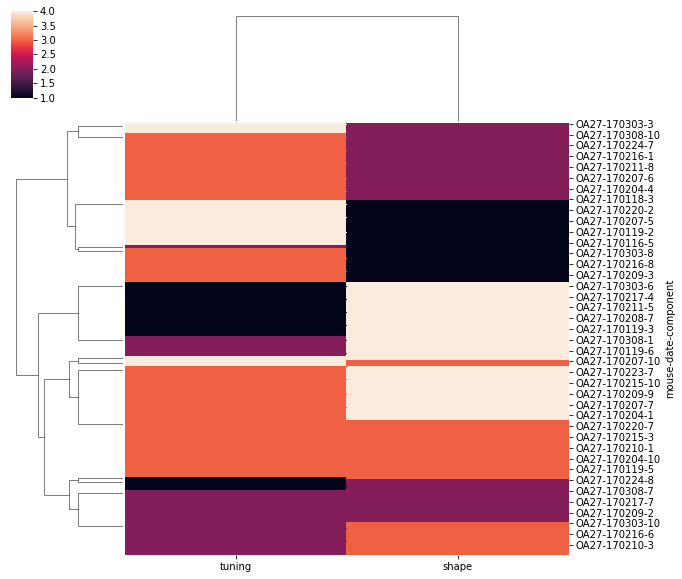

In [18]:
# create new df of tuning and
all_index_df['tuning'] = tuning_cluster
all_index_df['shape'] = shape_cluster
t = sns.clustermap(all_index_df, row_cluster=True)

In [ ]:
all_leaves = hierarchy.fcluster(t.dendrogram_row.linkage, 14, criterion='maxclust')
t.dendrogram_row.linkage

In [257]:
all_leaves
cmap2 = sns.color_palette("hls", 14)

array([1, 6, 6, 4, 2, 2, 4, 1, 6, 2, 6, 8, 1, 4, 2, 4, 4, 1, 3, 2, 2, 2,
       4, 4, 6, 4, 6, 4, 1, 1, 8, 6, 6, 1, 3, 5, 6, 5, 6, 1, 6, 4, 4, 1,
       1, 1, 2, 1, 2, 6, 6, 8, 2, 2, 1, 6, 4, 6, 4, 6, 6, 5, 4, 8, 2, 1,
       6, 8, 6, 5, 1, 1, 2, 6, 6, 6, 4, 3, 8, 8, 4, 8, 3, 3, 8, 6, 6, 1,
       6, 6, 6, 4, 8, 8, 6, 2, 3, 6, 4, 1, 3, 8, 6, 4, 4, 6, 8, 1, 6, 1,
       6, 1, 4, 6, 8, 3, 4, 6, 1, 8, 1, 8, 6, 1, 3, 6, 7, 8, 4, 6, 1, 4,
       6, 8, 7, 8, 2, 3, 6, 6, 8, 7, 1, 4, 4, 6, 8, 2, 6, 4, 8, 2, 6, 6,
       4, 1, 6, 3, 3, 8, 1, 1, 4, 7, 2, 3, 6, 7, 8, 8, 8, 6, 2, 3, 4, 8,
       1, 7, 1, 5, 2, 1, 1, 1, 6, 4, 8, 3, 6, 8, 4, 1, 6, 4, 3, 3, 8, 4,
       2, 1], dtype=int32)

In [307]:
all_index_df.head()

tuning  shape
mouse date   component               
OA27  170116 1               4      2
             2               3      4
             3               3      3
             4               2      4
             5               4      1

In [21]:
xday_clusters_df = []
for t in np.unique(all_index_df['tuning']):
    for s in np.unique(all_index_df['shape']):
#         if np.sum((all_index_df['tuning'] == t) & (all_index_df['tuning'] == s)) > 0:
        xday_clusters_df.append(np.where(((all_index_df['tuning'] == t) & (all_index_df['shape'] == s)) == True)[0])

In [ ]:
xday_clusters_df

In [22]:
xday_factors_tri = []
xday_factors_tempo = []
for idx in xday_clusters_df:
    day_inds = np.floor(idx/10)
    day_inds = [int(i) for i in day_inds]
    comp_inds = np.mod(idx,10)
    
    factors_tempo = []
    factors_tri = []
    for c, dind in enumerate(day_inds):
#         for cind in comp_inds[np.isin(day_inds, dind)]:
        factors_tempo.append(factors_by_day[dind].factors[1][:, comp_inds[np.isin(day_inds, dind)]])
        factors_tri.append(factors_by_day[dind].factors[2][:, comp_inds[np.isin(day_inds, dind)]])
#             factors_tempo.extend(factors_by_day[dind].factors[1][:, cind].T)
#             factors_tri.extend(factors_by_day[dind].factors[2][:, cind].T)
    xday_factors_tri.append(factors_tri)
    xday_factors_tempo.append(factors_tempo)

In [ ]:
xday_clusters_df

In [270]:
print(day_inds)
print(idx)
np.mod(idx,10)

[ 0.  1.  1.  2.  2.  4.  5.  6.  7.  8.  9.  9. 10. 10. 11. 11. 12. 12.
 13. 13. 14. 14. 14. 15. 16. 16. 16. 17. 17. 18. 19.]
[  6  13  16  22  23  42  58  62  76  80  91  98 103 104 112 116 126 128
 131 134 141 143 149 154 162 163 167 174 177 185 197]


array([6, 3, 6, 2, 3, 2, 8, 2, 6, 0, 1, 8, 3, 4, 2, 6, 6, 8, 1, 4, 1, 3,
       9, 4, 2, 3, 7, 4, 7, 5, 7])

In [ ]:
for i in xday_factors_tempo:
    plt.figure(figsize=(100,10))
    plt.plot(i)

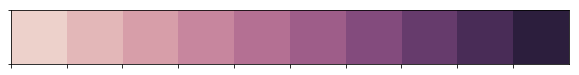

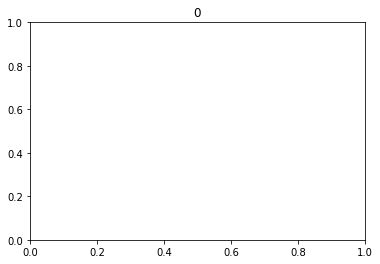

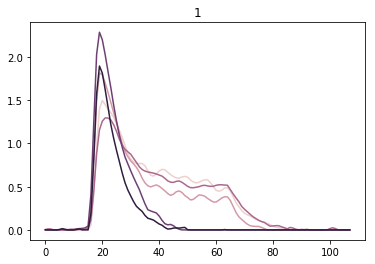

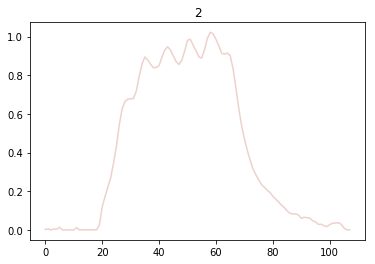

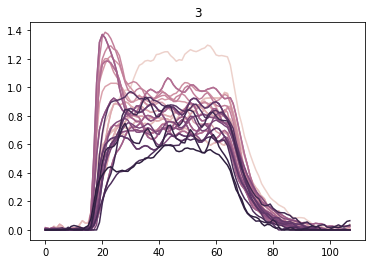

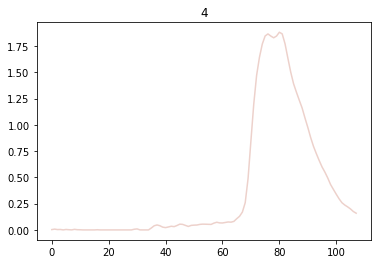

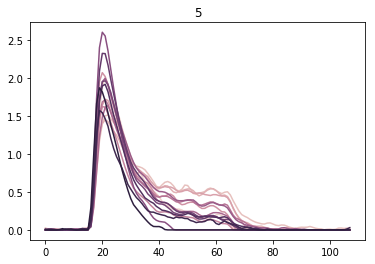

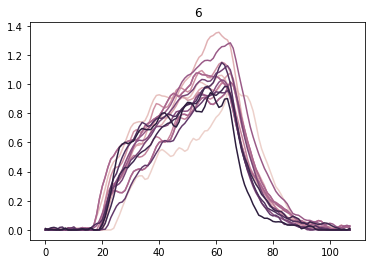

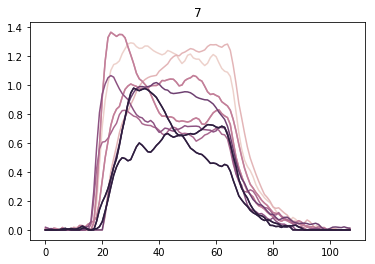

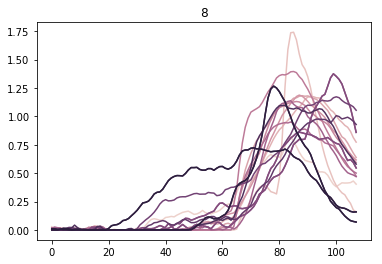

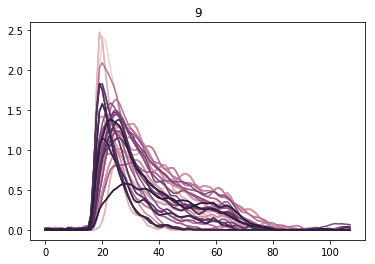

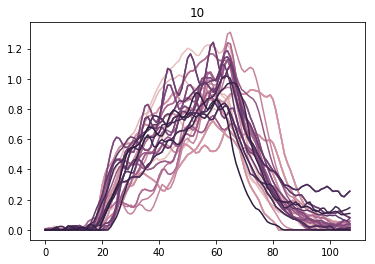

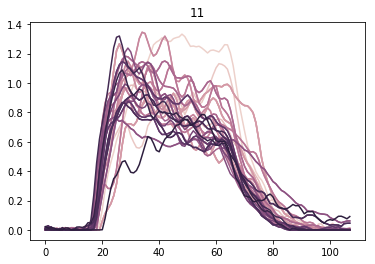

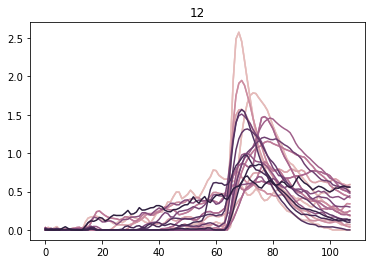

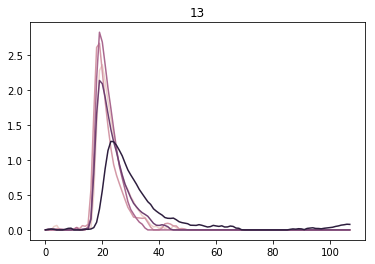

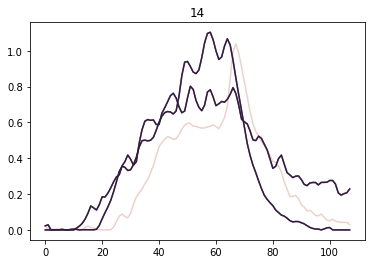

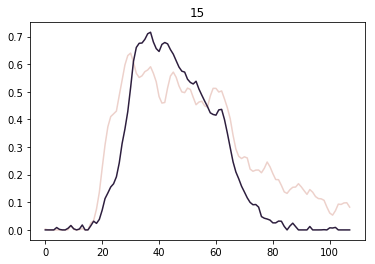

In [24]:
sns.palplot(sns.cubehelix_palette(10, as_cmap=False))
for c, k in enumerate(xday_factors_tempo):
    plt.figure()
    cmap = sns.cubehelix_palette(len(k), as_cmap=False)
    for c2, i in enumerate(k):
        plt.plot(i, color=cmap[c2])
    plt.title(str(c))
#     plt.legend()
# np.isin(day_inds, dind)